# CMPE 462 - Project Phase 3

Muhammed Furkan Atasoy, 2017400216

Zehranaz Canfes, 2017205138

In [ ]:
%matplotlib inline
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import os
from PIL import Image
from natsort import natsorted
import cv2
from mpl_toolkits import mplot3d
from sklearn import svm

In [ ]:
!unzip phase1_files.zip -d phase1_files

Streaming output truncated to the last 5000 lines.
  inflating: phase1_files/phase1_files/3dshapes_train/816.jpg  
  inflating: phase1_files/__MACOSX/phase1_files/3dshapes_train/._816.jpg  
  inflating: phase1_files/phase1_files/3dshapes_train/8418.jpg  
  inflating: phase1_files/__MACOSX/phase1_files/3dshapes_train/._8418.jpg  
  inflating: phase1_files/phase1_files/3dshapes_train/4222.jpg  
  inflating: phase1_files/__MACOSX/phase1_files/3dshapes_train/._4222.jpg  
  inflating: phase1_files/phase1_files/3dshapes_train/2653.jpg  
  inflating: phase1_files/__MACOSX/phase1_files/3dshapes_train/._2653.jpg  
  inflating: phase1_files/phase1_files/3dshapes_train/1372.jpg  
  inflating: phase1_files/__MACOSX/phase1_files/3dshapes_train/._1372.jpg  
  inflating: phase1_files/phase1_files/3dshapes_train/7703.jpg  
  inflating: phase1_files/__MACOSX/phase1_files/3dshapes_train/._7703.jpg  
  inflating: phase1_files/phase1_files/3dshapes_train/8430.jpg  
  inflating: phase1_files/__MACOSX/phase

In [ ]:
root_path = "/content/phase1_files/phase1_files/"

train_path = root_path + "3dshapes_train/"
test_path = root_path  + "3dshapes_test/"

train_img_paths = [train_path+x for x in natsorted(os.listdir(train_path))]
test_img_paths = [test_path+x for x in natsorted(os.listdir(test_path))]

train_imgs = np.array([np.array(Image.open(img_path).convert('L')).reshape(-1) / 255. for img_path in train_img_paths])
test_imgs = np.array([np.array(Image.open(img_path).convert('L')).reshape(-1) / 255. for img_path in test_img_paths])

train_orient = np.load(root_path + "orientations_train.npy")
test_orient = np.load(root_path + "orientations_test.npy")

In [ ]:
train_imgs.shape, test_imgs.shape, train_orient.shape, test_orient.shape

((10000, 4096), (1000, 4096), (10000,), (1000,))

## 1.a)

We know that 

$$Q = 
\begin{bmatrix}
    0       & 0_d^T\\
    0_d       & I_d
\end{bmatrix}
\text{ and } 
u = 
\begin{bmatrix}
    b\\
    w
\end{bmatrix}\in \mathbb{R}^{d+1}
$$

Being positive semi-definite is defined by the following equation:

$$ u^TQu \ge 0 \text{ for any } u.$$ 

After multiplying $u^T$ with $Q$, we obtain the following matrix:

$$
\begin{bmatrix}
    0 & w
\end{bmatrix}
$$
Then we need to show:
$ \begin{bmatrix}
    0 & w
\end{bmatrix} . \begin{bmatrix}
    b\\ w
\end{bmatrix} \ge 0$

$$ \implies w^2 \ge 0$$

which is true for all $w$. 

Therefore, we proved that $Q$ is positive-semidefinite. 

## 1.b)

$$\text{min}_{b,w} \frac 1 2 w^Tw\\ \text{subject to: }y_n(w^Tx_n+b)\ge 1\  \forall n$$


We are given:

$$ x = 
\begin{bmatrix}
    0 & 0\\
    0 & -1\\
    -2 & 0
\end{bmatrix}, \ 
y = \begin{bmatrix}
    -1\\
    -1\\
    1
\end{bmatrix}
$$

Applying the objective function we obtain the following equations:

(1) $-b\ge 1$

(2) $ -(-w_2+b))\ge 1$

(3) $-2w_1+b\ge 1$

- **(1) + (3)**: $-2w_1\ge 2 \implies -w_1\ge 1 \implies w_1\le -1$
- **(2) + (3)**: $-2w_1+w_2\ge 2 \implies w_2 \ge 0$

Using these objectives, maximize margin:

$\frac 1 2 w^T w = \frac 1 2 (w_1^2+w_2^2) \ge \frac 1 2$
$\implies w_1 = -1, w_2=0 \text{ and therefore, }b = -1$.

Thus, the optimal solution is: 
$w^*=\begin{bmatrix}
    -1\\
    0
\end{bmatrix},\ b^*=-1$

The optimal hyperplane is $g(x)=\text{sign}(-x_1-1)$

margin: $\frac{1}{||w||}=1$

Support vectors are: $(-2, 0),\ (0, 0),\ (0, -1)$.






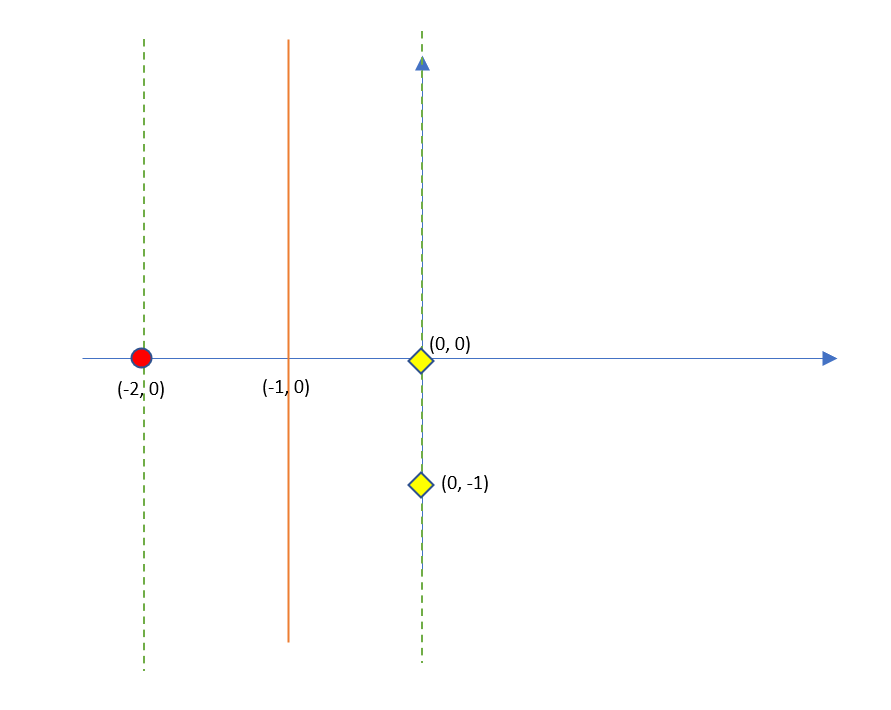

## 1.c)

We implemented hard-margin SVM by using cvxopt library. We found the corrospending matrices by looking at the library documentation. Because of their implemetation some of the matrices are needed to be multiplied by -1. In addition, we got the w and b arrays from solution of the optimizer. Finally, we plot the decision boundary and the data points. 

In [ ]:
def train_svm(X, y):
  n = X.shape[0]
  d = X.shape[1]
  y = y.reshape(1, -1)

  # Initialize the components
  Q = matrix(np.identity(d+1, dtype=np.float64))
  Q[0, 0] = 0
  p = matrix(np.zeros(d+1, dtype=np.float64))
  c = matrix(np.ones(n, dtype=np.float64))
  A = matrix(np.concatenate((y.T, (y * X.T).T), axis=1, dtype=np.float64))

  # Optimize
  sol = solvers.qp(Q, p, -A, -c)

  # Solution
  b = np.array(sol["x"][0])
  w = np.array(sol["x"][1:])

  return w, b

In [ ]:
def predict_svm(w, b, X):
  y_pred = np.sign(np.dot(X, w) + b).reshape(-1)
  return y_pred

In [ ]:
X = np.array([[0, 0],
              [0, -1],
              [-2, 0]])
y = np.array([-1, -1, 1])

In [ ]:
X.shape, y.shape

((3, 2), (3,))

In [ ]:
# Train
w, b = train_svm(X, y)

     pcost       dcost       gap    pres   dres
 0:  2.5606e-01  4.4983e-01  8e-01  1e+00  7e-16
 1:  3.8605e-01  4.8351e-01  4e-02  2e-01  2e-16
 2:  5.0271e-01  4.9877e-01  4e-03  2e-16  8e-16
 3:  5.0021e-01  4.9981e-01  4e-04  1e-16  4e-16
 4:  5.0003e-01  4.9997e-01  6e-05  1e-16  1e-16
 5:  5.0000e-01  5.0000e-01  8e-06  1e-16  2e-16
 6:  5.0000e-01  5.0000e-01  1e-06  1e-16  1e-16
 7:  5.0000e-01  5.0000e-01  2e-07  1e-16  3e-16
Optimal solution found.


In [ ]:
w, b

(array([[-1.00000001e+00],
        [ 3.93128191e-04]]), array(-1.00000001))

In [ ]:
# Predict
y_pred = predict_svm(w, b, X)
print("Predictions:", y_pred)

Predictions: [-1. -1.  1.]


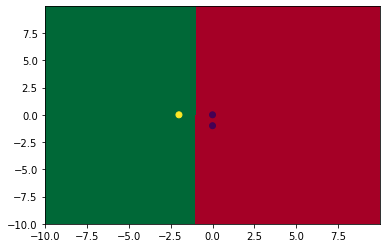

In [ ]:
# Plot the decision boundry
xx, yy = np.meshgrid(np.arange(-10, 10, 0.05), np.arange(-10, 10, 0.05))
y_pred = predict_svm(w, b, np.concatenate((xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)), axis=1))

plt.pcolormesh(xx, yy, y_pred.reshape(xx.shape), cmap="RdYlGn")
plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
print("w:", w, "b:", b)

w: [[-1.00000001e+00]
 [ 3.93128191e-04]] b: -1.0000000100315478


As it is clear, the optimal (b\*, w\*) found in 1b is the same as 1c. Also, the decision boundary is proved to be the same by the plot drawn in 1b and 1c. Therefore the margin and the support vectors are also the same. Note that there is a small difference between the weight and bias vectors in (b) and (c). This is probably because the optimizer couldn't find exactly the same point but it is very close.

## 1.d)

From previous phase, we found out that the best features are obtained by appling two convolutional filters first to get images, then applying PCA seperately to the obtained images. As a result, we obtained the most significant features. 

Then, we pre-processed the labels to get one-hot encoded representation of them.

### Feature Extraction

In [ ]:
# Feature Extraction
from skimage.filters import prewitt_h,prewitt_v

def extract_features(flat_imgs):
  imgs = flat_imgs.reshape(-1, 64, 64)
  horizontals = []
  verticals = []

  for img in imgs:
    horizontal = prewitt_h(img)
    vertical = prewitt_v(img)

    horizontals.append(horizontal.reshape(-1))
    verticals.append(vertical.reshape(-1))

  return np.array(flat_imgs), np.array(horizontals), np.array(verticals)

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(train, test, n_components):
  pca = PCA(n_components=n_components)
  train_reduced = pca.fit_transform(train)
  test_reduced = pca.transform(test)

  return train_reduced, test_reduced

In [ ]:
feature_count = 512

In [ ]:
# Extract additional features by applying horizontal and vertical edge detection filters and concatenate all of them to a single feature vector
flats_train, horizontals_train, verticals_train = extract_features(train_imgs)
flats_test, horizontals_test, verticals_test = extract_features(test_imgs)

flats_train, flats_test = apply_pca(flats_train, flats_test, feature_count)
horizontals_train, horizontals_test = apply_pca(horizontals_train, horizontals_test, feature_count)
verticals_train, verticals_test = apply_pca(verticals_train, verticals_test, feature_count)

train_features = np.concatenate((flats_train, horizontals_train, verticals_train), axis=1)
test_features = np.concatenate((flats_test, horizontals_test, verticals_test), axis=1)

### Train and Test SVM 

In [ ]:
def preprocess_labels(labels):
  # convert to class numbers from 0 to 14
  step_size = 4.28571429 # step size between orientations
  labels = np.round((labels+30) / step_size).astype(int)

  return labels

def convert_to_binary_labels(labels):
  return (labels > 7).astype(int) * 2 - 1 # map to -1 and 1

In [ ]:
def acc_metric(targets, preds):
  correct = np.sum(targets == preds)
  acc = correct / len(targets)
  
  return acc

In [ ]:
X_train = train_features
y_train = convert_to_binary_labels(preprocess_labels(train_orient))

X_test = test_features
y_test = convert_to_binary_labels(preprocess_labels(test_orient))

In [ ]:
# Train
w, b = train_svm(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  6.1371e+00  5.7423e+01  1e+04  1e+00  3e+04
 1:  2.0794e+01 -1.0028e+03  1e+03  9e-02  2e+03
 2:  1.2384e+01 -1.1692e+02  1e+02  1e-02  2e+02
 3:  5.6084e+00 -2.3241e+01  3e+01  2e-03  5e+01
 4:  3.4417e+00 -5.7353e+00  9e+00  7e-04  2e+01
 5:  3.0056e+00 -1.6760e+00  5e+00  3e-04  6e+00
 6:  2.7526e+00  1.0173e+00  2e+00  8e-05  2e+00
 7:  2.6691e+00  2.0135e+00  7e-01  2e-05  4e-01
 8:  2.6070e+00  2.3749e+00  2e-01  4e-06  9e-02
 9:  2.5951e+00  2.4385e+00  2e-01  2e-06  4e-02
10:  2.5829e+00  2.4930e+00  9e-02  1e-06  2e-02
11:  2.5839e+00  2.4950e+00  9e-02  9e-07  2e-02
12:  2.5758e+00  2.5435e+00  3e-02  3e-07  7e-03
13:  2.5745e+00  2.5551e+00  2e-02  2e-07  4e-03
14:  2.5741e+00  2.5591e+00  2e-02  1e-15  2e-12
15:  2.5734e+00  2.5699e+00  4e-03  1e-15  1e-11
16:  2.5734e+00  2.5708e+00  3e-03  1e-15  2e-11
17:  2.5733e+00  2.5732e+00  1e-04  2e-15  5e-11
18:  2.5733e+00  2.5733e+00  1e-06  1e-15  3e-11
Optimal solution foun

In [ ]:
# Predict
y_pred = predict_svm(w, b, X_train)
acc_train = acc_metric(y_train, y_pred)

y_pred = predict_svm(w, b, X_test)
acc_test = acc_metric(y_test, y_pred)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

---------------------------
Train Accuracy: 1.0 Test Accuracy: 1.0


The challenging part using cvxopt is the time required to train and test the classifier. It takes 16 seconds to complete the training. Also, it was hard to find correspondent Q, p, A, c matrices in cvxopt. 

## 1.e)

We use scikit-library's built-in implementation of the SVM to get single class SVM classifier.  

In [ ]:
X_train = train_features
y_train = convert_to_binary_labels(preprocess_labels(train_orient))

X_test = test_features
y_test = convert_to_binary_labels(preprocess_labels(test_orient))

In [ ]:
svm_model_single_class = svm.SVC()
svm_model_single_class.fit(X_train, y_train)

SVC()

In [ ]:
# Predict
y_pred = svm_model_single_class.predict(X_train)
acc_train = acc_metric(y_train, y_pred)

y_pred = svm_model_single_class.predict(X_test)
acc_test = acc_metric(y_test, y_pred)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

---------------------------
Train Accuracy: 1.0 Test Accuracy: 1.0


Training SVM classifier using scikit-learn is more efficient than using the cvxopt library. The training using scikit-learn takes 8 seconds, whereas using cvxopt it takes 16 seconds i.e. twice as long. 



We investigated the implementation detail of the SVM function in scikit-learn. They use libsvm as an optimizer (not same with us). Also, They claim that "The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples." which is better than ours. In addition, they use one-vs-one scheme to handle multi-class classification. Also, there are different options for the kernel trick in scikit-learn library.

## 1.f)

In [ ]:
X_train = train_features
y_train = preprocess_labels(train_orient)

X_test = test_features
y_test = preprocess_labels(test_orient)

### Without kernel trick

In [ ]:
svm_model_multi_class = svm.SVC(kernel="linear")
svm_model_multi_class.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Predict
y_pred = svm_model_multi_class.predict(X_train)
acc_train = acc_metric(y_train, y_pred)

y_pred = svm_model_multi_class.predict(X_test)
acc_test = acc_metric(y_test, y_pred)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

---------------------------
Train Accuracy: 0.9999 Test Accuracy: 1.0


### With kernel trick

In [ ]:
svm_model_multi_class = svm.SVC(kernel="rbf")
svm_model_multi_class.fit(X_train, y_train)

SVC()

In [ ]:
# Predict
y_pred = svm_model_multi_class.predict(X_train)
acc_train = acc_metric(y_train, y_pred)

y_pred = svm_model_multi_class.predict(X_test)
acc_test = acc_metric(y_test, y_pred)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

---------------------------
Train Accuracy: 0.9999 Test Accuracy: 1.0


Theoretically, using the kernel trick should improve the performance since it mimics the dot product and decreases the time complexity. Thanks to that, we can use more complex non-linear transformations. However, both of the classifiers predicted correctly for the majority of the classes. It might be thanks to extracting useful features and also smoothness of the synthetic dataset. As a time performance, the first one (without kernel trick: linear) took 15 seconds and the second one (with kernel trick: rbf) took 30 seconds so without kernel trick is more efficient because it has less amount of features (not non-linear transformation). 

## 1.g)

Normally we apply PCA to extract meaningful features of the dataset. In this part, we will train the model without applying PCA.

In [ ]:
# Extract additional features by applying horizontal and vertical edge detection filters and concatenate all of them to a single feature vector
flats_train, horizontals_train, verticals_train = extract_features(train_imgs)
flats_test, horizontals_test, verticals_test = extract_features(test_imgs)

train_features_without_PCA = np.concatenate((flats_train, horizontals_train, verticals_train), axis=1)
test_features_without_PCA = np.concatenate((flats_test, horizontals_test, verticals_test), axis=1)

In [ ]:
X_train = train_features_without_PCA
y_train = preprocess_labels(train_orient)

X_test = test_features_without_PCA
y_test = preprocess_labels(test_orient)

In [ ]:
svm_model_multi_class_without_PCA = svm.SVC(kernel="rbf")
svm_model_multi_class_without_PCA.fit(X_train, y_train)

SVC()

In [ ]:
# Predict
y_pred = svm_model_multi_class_without_PCA.predict(X_train)
acc_train = acc_metric(y_train, y_pred)

y_pred = svm_model_multi_class_without_PCA.predict(X_test)
acc_test = acc_metric(y_test, y_pred)

print("---------------------------")
print("Train Accuracy:", acc_train, "Test Accuracy:", acc_test)

---------------------------
Train Accuracy: 0.998 Test Accuracy: 0.999


After running the code, it is clear that it takes much more time to train the SVM classifier without applying PCA because PCA decreases the amount of the features. Also, the results show that the accuracy with PCA is more than the one without PCA. 

# 1.h)

At Phase 1, we implemented the linear regression model. To decrease the amount of time for the larger dataset, we implemented PCA similarly to our Phase 3 method. PCA decreased the Mean Square Error and the total time passed. This is a similar result 1.g.). 

In the Phase 2, we implemented logistic regression. We used the features we extracted in Phase 1. In this phase we used cross entropy loss and the softmax function for the optimization and calculated the accuracy results after training the model. We obtained 

```
Train Accuracy: 0.9962 Test Accuracy: 0.996
```
We extracted more features by applying convolutional filters and PCA to the resulting images. This increased our accuracy results: 

```
Train Accuracy: 1.0 Test Accuracy: 1.0
```

Moreover, we implemented a Naive Bayes Classifier which also gave the same accuracy results as the final version of logistic regression. Both of the classifiers predicted correctly for the majority of the classes. It might be thanks to extracting useful features and also smoothness of the synthetic dataset. 



All of these classifiers gave high accuracy results i.e. 1.0. after extracting the features using both PCA and convolutional filters. We can say that this is due to the simplicity of our dataset. 

# 2.a)

Gaussian mixture is combination of different gaussian distributions so firstly we need to choose which gaussian distrubution we will use for each sampling. 

The pi values are the probabilities of the distributions to be choosen for each sampling. Therefore, We uniformly sampled a value between 0 and 1 and pick the normal distribution according to this random value.

After choosing mean values for the gaussian distrubution, we sampled a point from that with help of `random.normal ` functionality of numpy library. Then, we repeated same procedure until the desired number of sample obtained.

In [ ]:
num_of_sample = 500
samples = np.zeros((num_of_sample, 2))
classes = np.zeros(num_of_sample)

mu_list = [(0,1), (1,0), (-1,0), (0,-1)]
accumulated_pi_list = [0.25, 0.5, 0.75, 1.0]
var = 1
mu = None

for i in range(num_of_sample):
  r = np.random.uniform(0, 1)

  for j, threshold in enumerate(accumulated_pi_list):
    if r < threshold:
      mu = mu_list[j]
      break

  classes[i] = j
  samples[i] = np.random.normal(mu, var, 2)

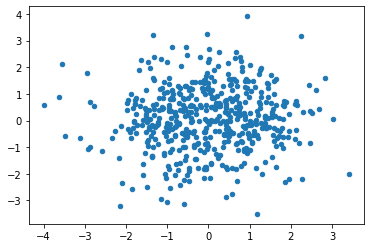

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1], s=20, linewidths=1)

# 2.b)

In [ ]:
def fit_k_means(X, k=4):
  centroids_history = []
  clusters_history = []

  initial_centroid_indexes = np.random.choice(range(X.shape[0]), size=k)
  centroids = X[initial_centroid_indexes]

  old_centroids = np.zeros(shape=centroids.shape)

  # Fit model
  while not np.array_equal(old_centroids, centroids):
    distance_matrix = np.repeat(np.expand_dims(centroids,1), repeats=X.shape[0], axis=1)
    distance_matrix = np.sqrt(np.sum((distance_matrix - X)**2, axis=2))

    clusters = np.argmin(distance_matrix, axis=0)

    old_centroids = np.copy(centroids)
    for i in range(k):
      indexes = np.where(clusters==i)
      values = X[indexes]
      new_centroid = np.mean(values, axis=0)
      centroids[i] = new_centroid
    
    centroids_history.append(old_centroids)
    clusters_history.append(clusters)

  # Plot history
  fig, axs = plt.subplots(nrows=len(centroids_history), figsize=(6, 6*len(centroids_history)))
  for i in range(len(centroids_history)):
    centroids = centroids_history[i]
    clusters = clusters_history[i]

    axs[i].scatter(X[:, 0], X[:, 1], c=clusters, s=20, linewidths=1)
    axs[i].scatter(centroids[:, 0], centroids[:, 1], c="black", marker="+", s=300, linewidths=3)
    axs[i].set_title(f"Iteration {i}")  

  
  return centroids_history[-1], clusters_history[-1]

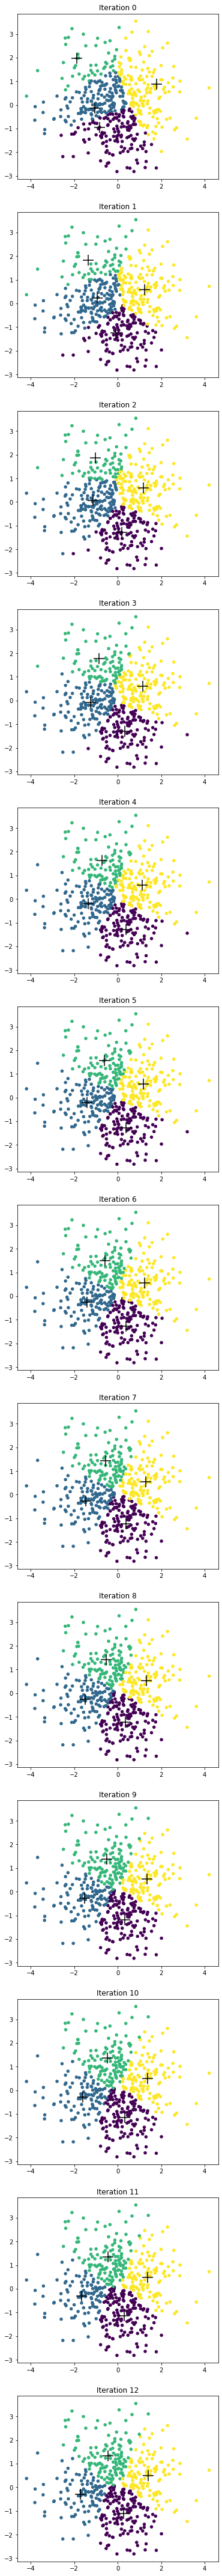

In [ ]:
final_centroids, final_clusters = fit_k_means(samples, k=4)

Original Centroids: [[ 0  1]
 [ 1  0]
 [-1  0]
 [ 0 -1]]
Predicted Centroids: [[ 0.27370713 -1.11578084]
 [-1.70430696 -0.29541551]
 [-0.45122432  1.33975961]
 [ 1.40806014  0.49277114]]


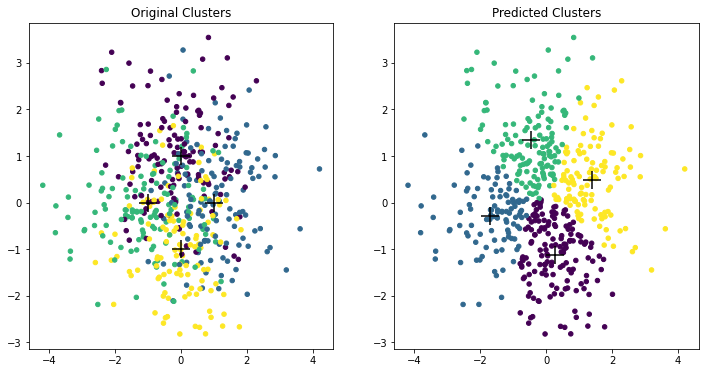

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6*2, 6))

original_centroids = np.array(mu_list)

axs[0].scatter(samples[:, 0], samples[:, 1], c=classes, s=20, linewidths=1)
axs[0].scatter(original_centroids[:, 0], original_centroids[:, 1], c="black", marker="+", s=300, linewidths=3)
axs[0].set_title("Original Clusters")

axs[1].scatter(samples[:, 0], samples[:, 1], c=final_clusters, s=20, linewidths=1)
axs[1].scatter(final_centroids[:, 0], final_centroids[:, 1], c="black", marker="+", s=300, linewidths=3)
axs[1].set_title("Predicted Clusters")

print("Original Centroids:", original_centroids)
print("Predicted Centroids:", final_centroids)

The model couldn't cluster the samples correctly. Because, the mean values of the distributions are closer to each other so that when we add the variations to the means, distributions are intersecting with each other. 

In this condition, the model couldn't achieve to cluster samples correctly because they are intersecting with each other and it is not possible to cluster data points correctly with k-means algorithm because it mainly looks the euclidean distances of the points and it is not possible to predict correctly only by looking at their distances. However, the centroids of the predicted clusters are close to the centroids of the original clusters.

Hence, we can say that if we choose bigger mean values relative to variations, the k-means model also can successfully cluster datapoints. 

# References

- https://github.com/liubai01/hard-margin-SVM-tutorial-by-cvxopt
- https://medium.com/analytics-vidhya/sampling-from-gaussian-mixture-models-f1ab9cac2721
- https://moodle.boun.edu.tr/pluginfile.php/1044662/mod_resource/content/1/Lec08-Clustering.pdf